In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import operator

plt.figure(figsize=(15,15))

import cv2
import numpy as np

%matplotlib inline

# https://aishack.in/tutorials/sudoku-grabber-opencv-detection/
# https://mc.ai/sudoku-solver-using-opencv-and-dl%E2%80%8A-%E2%80%8Apart-1/

[array([ 54, 147], dtype=int32), array([1442,  148], dtype=int32), array([1441, 1615], dtype=int32), array([  50, 1613], dtype=int32)]
[ 54 147] [1442  148] [1441 1615] [  50 1613]


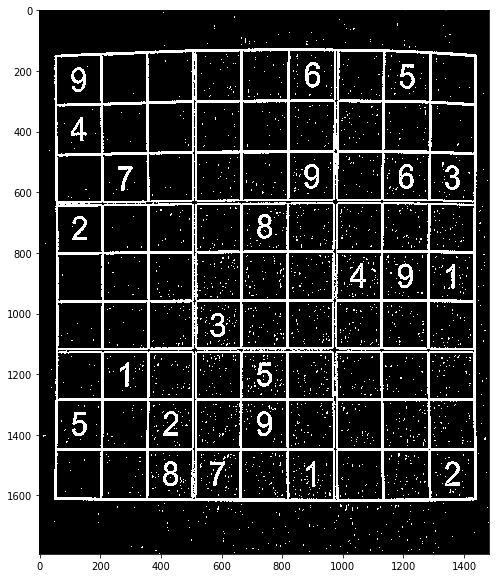

In [181]:
#read image
image = cv2.imread('1.jpg')

#gaussian blur
image = cv2.GaussianBlur(image, (11, 11), 0)

#to gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#adaptiveThreshold(sudoku, outerBox, 255, ADAPTIVE_THRESH_MEAN_C, THRESH_BINARY, 5, 2);
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)

#invert the image outerBox
thresh = cv2.bitwise_not(thresh, thresh)

#sharpening?
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
thresh = cv2.dilate(thresh, kernel)

contours, h = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]

bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in  polygon]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in  polygon]), key=operator.itemgetter(1))

print([polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]])

crop_rect=[polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

print(crop_rect[0],crop_rect[1], crop_rect[2], crop_rect[3])

#top-left:[54 147]
#top-right: [50 1613]
#bottom-right: [1441 1615]
#bottom-left: [1442  148]

plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap='gray');

[[  54.  147.]
 [1442.  148.]
 [1441. 1615.]
 [  50. 1613.]]
Width:  1391 Height:  1467
Wall time: 16 ms


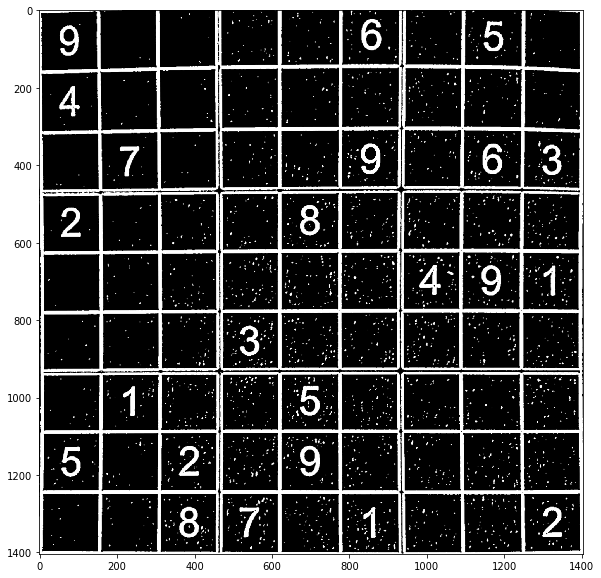

In [182]:
def order_points(pts):
    # list of coordinates 
    # - first entry: top-left,
    # - second entry: top-right, 
    # - third: bottom-right, fourth: bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    print(rect)
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    
    print('Width: ', maxWidth, 'Height: ', maxHeight)
    
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    warped_r = cv2.resize(warped, (1404, 1404))
    
    
    
    # return the warped image
    return warped_r


# crop_rect = [[54,147],[1442,148],[1441,1615],[50,1613]]
pts = np.asarray(crop_rect)

%time warped = four_point_transform(thresh, pts)
plt.figure(figsize=(10,10))
plt.imshow(warped, cmap='gray');

In [183]:
squares = [] 
side = warped.shape[:1] 
side = side[0] / 9
for j in range(9):
     for i in range(9):
        p1 = (i * side, j * side) #Top left corner of a box 
        p2 = ((i + 1) * side, (j + 1) * side) #Bottom right corner 
        squares.append((p1, p2)) 
print(type(squares))

print(squares[0])

<class 'list'>
((0.0, 0.0), (156.0, 156.0))


In [197]:
image = warped.copy()
cropped = image[0:0, 156:156]

num = rect = np.zeros((81, 156,156), dtype = "float32")
print(num.shape)
#plt.imshow(cropped, cmap='gray');
#cv2.imwrite("thumbnail.png", cropped)

y=156
x=156
h=156
w=156

def crop_squares(): 
    k=0
    for y in range(9):
        for x in range(9):
            #print(k,'|', y*156, (y+1)*h, x*156, (x+1)*w)
            num[k] = image[y*156:(y+1)*h, x*156:(x+1)*w] # [0:156, 0,156]
            
            kernel = np.ones((5,5),np.uint8)
            num[k] = cv2.morphologyEx(num[k], cv2.MORPH_OPEN, kernel)
            k += 1
           

crop_squares()           

#numbers[0] = crop
#print(crop.shape)
#print(type(crop))

#cropp = crop.reshape([1, 156, 156])
#print(cropp.shape)

np.save('file.npz',num)

from PIL import Image
#im = Image.fromarray(crop)
#im.save("00.jpg")

(81, 156, 156)


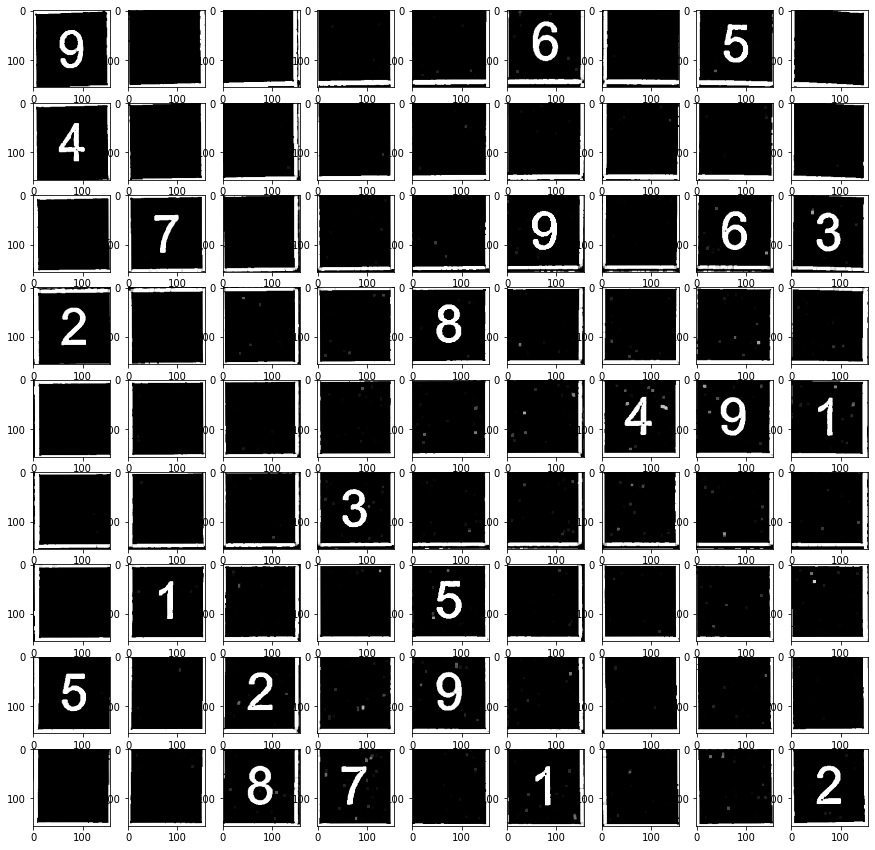

In [198]:
fig = plt.figure(figsize=(15, 15))
for idx in range(81):
    plt.subplot(9,9,idx+1)
    plt.imshow(num[idx], cmap='gray', interpolation='none')

In [200]:
print(num.shape)
img = resize(num, (81,28, 28), mode='constant')
print(img.shape)


cv2.floodFill(img[0], None, (0,0), 0)

pd.DataFrame(img[0]).style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

(81, 156, 156)
(81, 28, 28)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,199.109909,212.558243,221.496475,224.176056,224.161682,222.944275,221.051682,220.879166,220.710953,219.727463,213.987579,213.148392,213.130264,209.634827,199.095306,198.026764,198.019699,196.629837,178.993988,174.975632,178.557068,174.163208,172.477676,153.596680,138.271851,104.739716,158.747681,196.928940
1,202.786163,134.243317,138.567261,139.199188,138.865433,123.371658,99.484375,97.754906,96.718842,91.997238,64.454254,60.417294,60.378696,53.814857,34.272820,32.610191,32.604275,31.615677,19.062195,16.203995,18.762646,15.697135,15.064620,10.140100,6.521850,3.904020,69.438278,212.385635
2,203.144012,41.132931,3.241555,3.212564,3.179076,2.346998,1.094963,1.013757,0.983434,0.889710,0.343585,0.263490,0.263105,0.213594,0.067224,0.055884,0.055864,0.053113,0.018146,0.010184,0.017335,0.008863,0.007798,0.003477,0.000454,0.608843,76.238098,215.655731
3,206.802750,43.909603,0.125399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.253006,53.587452,208.366272
4,209.047516,50.468880,0.201400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600123,75.845818,215.608627
5,215.043839,68.387390,0.421623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000202,0.001069,0.001886,0.000360,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.670779,80.372643,217.077957
6,218.169846,78.213654,0.550619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002353,0.242288,3.129503,7.662474,10.272958,3.585233,0.150710,0.000472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354537,59.562355,210.058533
7,216.470657,73.113113,0.487767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006334,1.943945,41.697990,125.175644,171.290863,185.266739,124.147629,27.545280,0.810796,0.001452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168628,47.282520,205.896240
8,211.057205,56.827236,0.287925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000505,1.204740,55.914005,207.693542,239.293045,205.359558,201.652466,241.163483,186.148956,34.036602,0.308822,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.160644,46.439503,205.467590
9,217.640961,77.510719,0.565703,0.000000,0.000000,0.000000,0.000000,0.000000,0.062227,23.287464,188.108780,239.479996,104.272369,21.885084,22.419016,130.301498,242.253922,139.932495,5.855049,0.001710,0.000000,0.000000,0.000000,0.000000,0.000000,0.224725,50.712643,206.936569


In [187]:
if np.max(img) > 1: img /= 255

pd.DataFrame(img[0]).style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.781040,0.845654,0.871095,0.880724,0.879710,0.874547,0.872425,0.867081,0.865534,0.861679,0.841301,0.844176,0.835981,0.822102,0.783707,0.783598,0.776625,0.771097,0.701948,0.690906,0.722759,0.684164,0.676461,0.619590,0.593636,0.444890,0.633252,0.772339
1,0.795293,0.526564,0.550912,0.596835,0.565056,0.487098,0.460306,0.394562,0.379299,0.360788,0.262975,0.276802,0.237632,0.211048,0.139839,0.140825,0.128002,0.123983,0.074761,0.066918,0.089626,0.062392,0.059085,0.043906,0.038055,0.015947,0.272745,0.832957
2,0.796820,0.161798,0.013729,0.019465,0.015228,0.009384,0.007973,0.004563,0.003857,0.003489,0.001550,0.001824,0.001049,0.000838,0.000304,0.000316,0.000220,0.000208,0.000071,0.000049,0.000113,0.000037,0.000031,0.000017,0.000013,0.002391,0.299140,0.845746
3,0.825452,0.213991,0.000966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000992,0.210147,0.817123
4,0.840488,0.258952,0.001518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002353,0.297435,0.845524
5,0.847707,0.281267,0.001809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000005,0.000007,0.000001,0.000000,0.000060,0.005749,0.003623,0.000018,0.000000,0.000000,0.000000,0.000000,0.002635,0.315489,0.851391
6,0.855585,0.306771,0.002160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000953,0.013656,0.033264,0.040374,0.014060,0.000591,0.001530,0.144492,0.102630,0.000597,0.000000,0.000000,0.000000,0.000000,0.001429,0.236164,0.824653
7,0.848905,0.286718,0.001913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000025,0.007623,0.163539,0.498351,0.689203,0.727017,0.486853,0.108021,0.003400,0.026132,0.021473,0.000127,0.000000,0.000000,0.000000,0.000000,0.000662,0.185492,0.807461
8,0.827675,0.222853,0.001129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.004724,0.219271,0.814485,0.938561,0.805707,0.790805,0.945739,0.729996,0.133477,0.001242,0.000028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000630,0.182116,0.805755
9,0.853637,0.304685,0.002235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000244,0.091323,0.737682,0.939137,0.408911,0.085824,0.087918,0.510986,0.950015,0.548755,0.022961,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000889,0.199253,0.811598


In [ ]:
img = img.reshape(81,784)
#X_train = X_train.reshape(60000, 784)
print(img.shape)



## Neutral Network - TF

In [143]:
import numpy as np
np.random.seed(0)

#Tensorflow
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from keras.models import load_model

(X_train, y_train), (X_test, y_test) = mnist.load_data()


if len(X_train.shape) == 3:
    num_pixels = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape(X_train.shape[0], num_pixels).astype("float32")
    X_test = X_test.reshape(X_test.shape[0], num_pixels).astype("float32")

print(X_train.shape, X_test.shape)

#skalujemy od 0 do 1
if np.max(X_train) > 1: X_train /= 255 # A = A / B
if np.max(X_test) > 1: X_test /= 255

#one-hot encoding dla zmiennej docelowej - Tensorflow
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]

model = Sequential([
    Dense(512, input_dim=num_pixels, activation='relu'),
    Dropout(0.5), #wylącz 50% neuronów
    Dense(256, activation='relu'),
    Dropout(0.2), #wylącz 20% neuronów
    Dense(num_classes, kernel_initializer='normal', activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

(60000, 784) (10000, 784)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [144]:
model.fit(X_train, y_train,
          batch_size=1024, epochs=10, verbose=2,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 3s - loss: 2.3293 - accuracy: 0.1137 - val_loss: 2.3100 - val_accuracy: 0.1271
Epoch 2/10
60000/60000 - 3s - loss: 2.3220 - accuracy: 0.1159 - val_loss: 2.3014 - val_accuracy: 0.1374
Epoch 3/10
60000/60000 - 2s - loss: 2.3145 - accuracy: 0.1225 - val_loss: 2.2928 - val_accuracy: 0.1475
Epoch 4/10
60000/60000 - 2s - loss: 2.3062 - accuracy: 0.1294 - val_loss: 2.2842 - val_accuracy: 0.1599
Epoch 5/10
60000/60000 - 2s - loss: 2.2979 - accuracy: 0.1386 - val_loss: 2.2756 - val_accuracy: 0.1717
Epoch 6/10
60000/60000 - 2s - loss: 2.2895 - accuracy: 0.1453 - val_loss: 2.2669 - val_accuracy: 0.1876
Epoch 7/10
60000/60000 - 2s - loss: 2.2812 - accuracy: 0.1553 - val_loss: 2.2583 - val_accuracy: 0.2004
Epoch 8/10
60000/60000 - 2s - loss: 2.2734 - accuracy: 0.1619 - val_loss: 2.2497 - val_accuracy: 0.2175
Epoch 9/10
60000/60000 - 3s - loss: 2.2641 - accuracy: 0.1721 - val_loss: 2.2410 - val_accuracy: 0.2342
Epoch 10/10
60

In [145]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("MLP Error: %.2f%%" % (100-score[1]*100))

Test loss: 2.2323371627807616
Test accuracy: 0.2529
MLP Error: 74.71%


In [135]:
model.save('MNIST.h5')

In [177]:
from skimage.transform import resize
print(num.shape)
img = resize(num, (81,28, 28), mode='constant')
print(img.shape)
img = img.reshape(81,784)
#X_train = X_train.reshape(60000, 784)
print(img.shape)

if np.max(img) > 1: img /= 255

preds = model.predict_classes(img)
prob = model.predict_proba(img)
p = model.predict(img)
print(preds[0], prob[0], p[0])

(81, 156, 156)
(81, 28, 28)
(81, 784)
6 [0.10130103 0.11818437 0.08316194 0.10754317 0.10571159 0.09815925
 0.13709594 0.08904096 0.08359568 0.0762061 ] [0.10130103 0.11818437 0.08316194 0.10754317 0.10571159 0.09815925
 0.13709594 0.08904096 0.08359568 0.0762061 ]


---

# Poligon doświadczalny

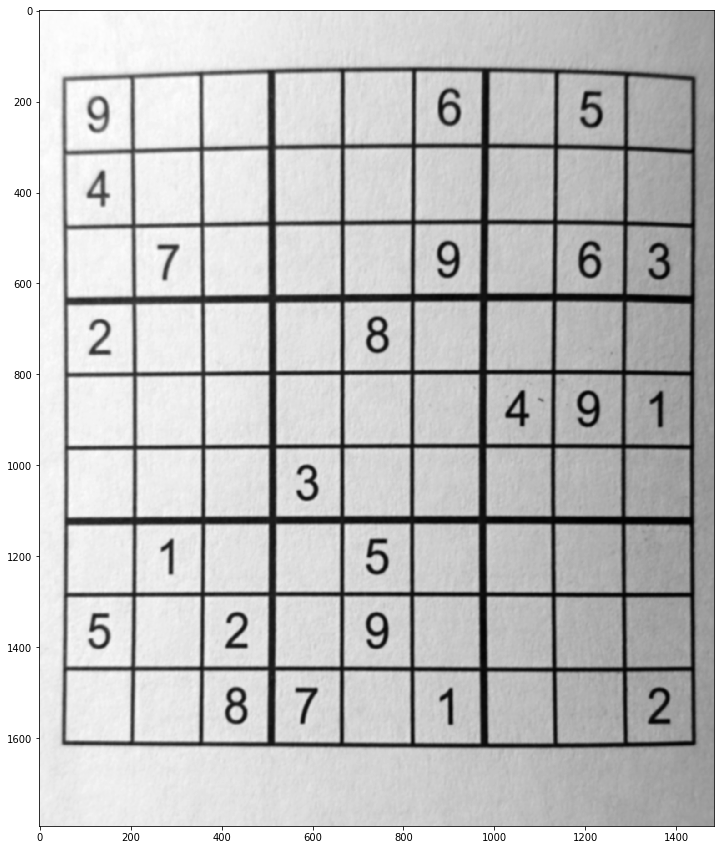

In [18]:
def preprocessImg(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    plt.figure(figsize=(15,15))
    plt.imshow(gray, cmap='gray');
    # gray = cv.GaussianBlur(gray, (11, 11), 0)
    # outerBox = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 5, 2)
    #ret,thresh = cv.threshold(gray,128,255,cv.THRESH_BINARY)
    # cv.imshow('thresh', thresh)
    #outerBox = cv.bitwise_not(thresh)
    #cv.imshow('BitwiseNot', outerBox)
    #return outerBox

image = cv2.imread('1.jpg')
preprocessImg(image)

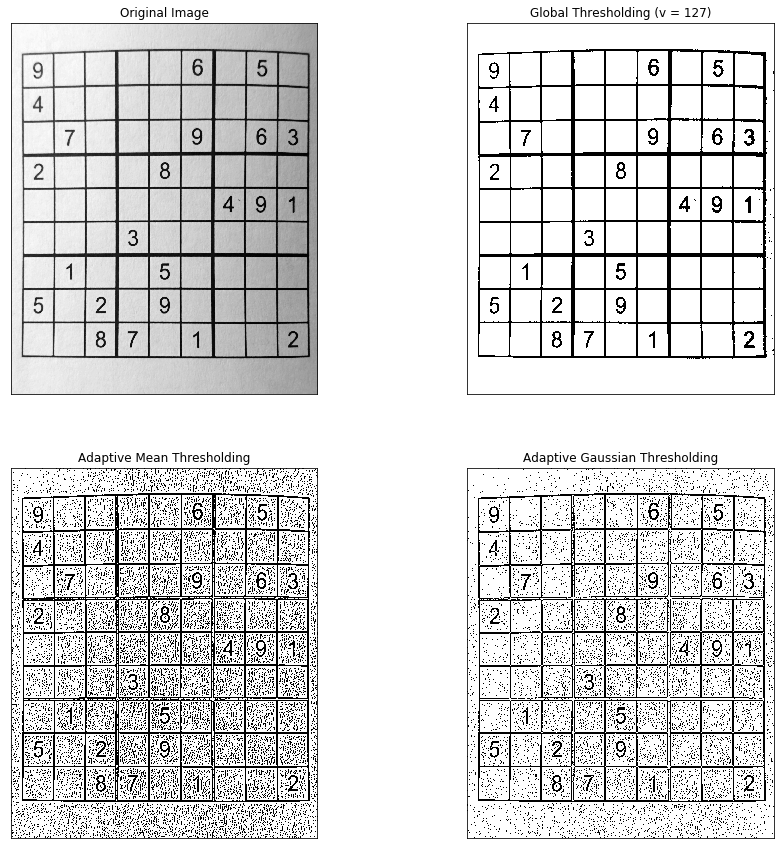

In [23]:
img = cv2.imread('1.jpg',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,130,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

plt.figure(figsize=(15,15))

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()